# Examining performance of SKLearn and wepredict on simulated data

In [1]:
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
import pickle
from tqdm import tqdm
%matplotlib inline

In [61]:
pheno_path = '../data/sim_1000G_chr10.txt'

The data display below shows the structure of the data.
I only used the first phenotype in the current simulations

In [62]:
pheno = pd.read_table(pheno_path)
pheno.head()

,FID,IID,PAT,MAT,SEX,V6,V1,V2,V3,V4
0,0,HG00096,0,0,0,-9,1.391821,1.138268,2.070238,-0.372672
1,0,HG00097,0,0,0,-9,-1.187275,2.092036,0.692091,0.048933
2,0,HG00099,0,0,0,-9,0.133182,0.638893,-0.529870,-1.335510
3,0,HG00100,0,0,0,-9,-1.170558,1.796703,1.220772,-1.487219
4,0,HG00101,0,0,0,-9,1.556918,1.210081,-1.837264,-0.456114


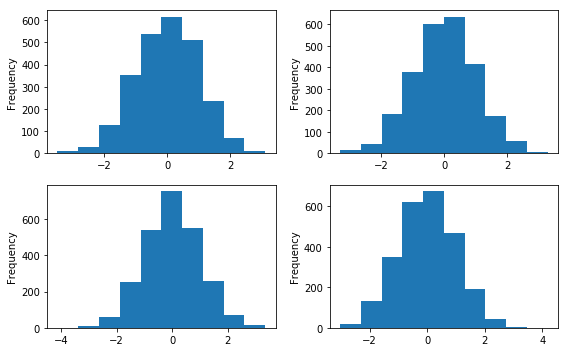

In [63]:
fig, ax = plt.subplots(2,2, figsize=(8, 5))
pheno_names = ['V'+str(i) for i in np.arange(1, 5)]
itere = np.array(pheno_names).reshape(2,2)
for i, n in np.ndenumerate(itere):
    pheno[n].plot(kind='hist', ax=ax[i])
fig.tight_layout()

## Analysis part

I first checked for sample overlap and integrated the phenotype data with the fam file of the plink files.
Furthermore, I generated blocks of SNPs by LD blocks as described by Berisa et. al.

In [5]:
from wepredict.wepredict import wepredict

In [64]:
plink_path = '../data/sim_1000G_chr10'
ld_block_path = '../data/Berisa.EUR.hg19.bed'

In [65]:
monster = wepredict(plink_path, ld_block_path, pheno_path)

In [66]:
monster.pheno.head()

,fid,iid,father,mother,gender,status,V6,V1,V2,V3,V4
0,0,HG00096,0,0,0,-9,-9,1.391821,1.138268,2.070238,-0.372672
1,0,HG00097,0,0,0,-9,-9,-1.187275,2.092036,0.692091,0.048933
2,0,HG00099,0,0,0,-9,-9,0.133182,0.638893,-0.529870,-1.335510
3,0,HG00100,0,0,0,-9,-9,-1.170558,1.796703,1.220772,-1.487219
4,0,HG00101,0,0,0,-9,-9,1.556918,1.210081,-1.837264,-0.456114


## Training the model

- Training sample size is $(1-0.2)*n$
- Validation sample size is $(1-0.2)*n*0.15$

In [88]:
blocks = monster.blocks[10]
sample_index = monster.generate_valid_test_data(0.2, 0.15)
y =  monster.pheno['V1'].values

Using 30 alpha values


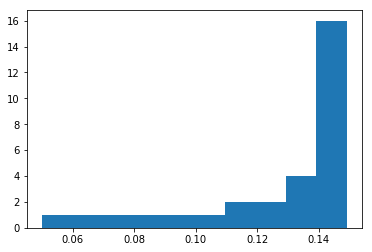

In [120]:
alphas = list()
with open('../data/lasso_benchmark_lambda.txt', 'r') as f:
    next(f)
    for line in f:
        alphas.append(0.15-float(line))
print('Using', len(alphas), 'alpha values')
histo = plt.hist(alphas)

In [121]:
save_path = '../data/save_serial_l1_new_test_sklearn.pickle' 
re_run = True
if re_run:
    out_blocks = list()
    for i in tqdm(range(len(blocks))):
        mat = monster.block_read(10, blocks[i])
        sample = monster.get_samples(mat, y, sample_index[0],
                                     sample_index[1])
        del mat
        out = monster.compute_lasso(sample['training_x'],
                                     sample['training_y'], 
                                     sample['valid_x'], 
                                     sample['valid_y'], alphas=alphas)
        out_blocks.append(out)
    del sample
    pickle.dump(out_blocks, open(save_path, 'wb')) 
else:
    out_blocks = pickle.load(open(save_path, 'rb'))

  0%|          | 0/85 [00:00<?, ?it/s]/home/robert/software/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3183: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/robert/software/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3184: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
100%|██████████| 85/85 [07:11<00:00,  5.08s/it]


## Result analysis

In [116]:
prop_block = list()
for i in range(len(out_blocks)):
    a1 = out_blocks[i]
    prop_alpha = list()
    for a in range(len(alphas)):
        params = [k['model'][1][:, a] for k in out_blocks]
        params = np.concatenate(params)
        prop_alpha.append(np.mean(params==0))
    prop_block.append(prop_alpha)

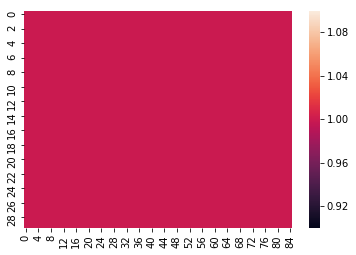

In [117]:
proportion_null = np.column_stack(prop_block)
sns.heatmap(proportion_null)

## Block wise prediction

/home/robert/software/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3183: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/robert/software/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3184: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/robert/software/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)
/home/robert/software/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


ValueError: max must be larger than min in range parameter.

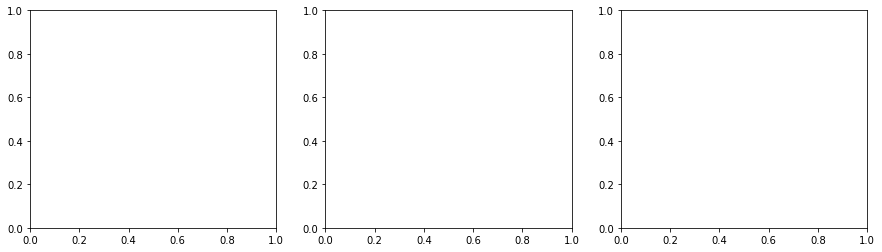

In [110]:
import seaborn as sns
used_alpha = 1
y_hat_block = [k['pred'][:, used_alpha] for k in out_blocks]
y_hat_block = np.column_stack(y_hat_block)

fig, ax = plt.subplots(1, 3, figsize=(15, 4))
y_hat = y_hat_block.sum(axis=1)
pp = list()
for i in range(y_hat_block.shape[1]):
    pp.append(np.corrcoef(out_blocks[0]['pheno'], y_hat_block[:, i])[0, 1])
ax[0].hist(pp)

correlation_pred = np.corrcoef(y_hat_block.T)
sns.heatmap(correlation_pred, ax=ax[1])
low_corr = np.tril(correlation_pred, k=-1)
low_corr = low_corr.flatten()
low_corr = low_corr[np.nonzero(low_corr)]
ax[2].hist(low_corr)
ax[2].set_title('Hist of Block corr')

ax[0].set_title('Block-wise prediction')
ax[1].set_title('Block-wise prediction corr')
fig.show()

Clearly the performance for each block is non-correlated, but the distribution seems a bit odd.
There are a number of blocks which have a higher prediction as one would expect.

## Overall prediction

In [80]:
y_hat = y_hat_block.sum(axis=1)
y = out_blocks[0]['pheno']
all_corr = np.corrcoef(y, y_hat)[1, 0]
print('Overall correlation:', all_corr)

Overall correlation: 0.033369420558197894


Goal is 0.05

### Wighted sum of the prediction

I tried to use a weighted version of the sum with a linear regression

In [77]:
from sklearn.linear_model import Lasso
model = Lasso(alpha=0.05)
model.fit(y_hat_block, y)
score = model.score(y_hat_block, y)
print('The insample prediction is then:', score)
weights = model.coef_

The insample prediction is then: 0.04846036728238812


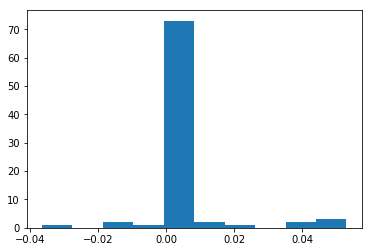

In [79]:
hh = plt.hist(weights)

However, the histogram indicates that many of those are actually not zero. 
I think its over-fitting.

In [4]:
%matplotlib inline
%run '../testing_regression.py'

/home/robert/software/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:164: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/home/robert/software/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:181: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


Best Torch model l0 : -0.007304563701640566 with 100
Best Torch model l1 : 0.04089197902437718 with 100
Best Torch model l0 : 0.103829274769177 with 166
Best Torch model l1 : 0.05299703803069217 with 166
Best Torch model l0 : 0.08677213252254685 with 278
Best Torch model l1 : 0.041594795756416274 with 278
Best Torch model l0 : 0.08510959690031998 with 464
Best Torch model l1 : 0.15422066862245493 with 464
Best Torch model l0 : 0.131104508933828 with 774
Best Torch model l1 : 0.24765856662021052 with 774
Best Torch model l0 : 0.24231770267682115 with 1291
Best Torch model l1 : 0.35900388789842935 with 1291
Best Torch model l0 : 0.40315737085036885 with 2154
Best Torch model l1 : 0.48185309504873364 with 2154
Best Torch model l0 : 0.5780764100191733 with 3593
Best Torch model l1 : 0.5100661922661223 with 3593
Best Torch model l0 : 0.6688251734250811 with 5994
Best Torch model l1 : 0.5672657137532352 with 5994
Best Torch model l0 : 0.6927485343295469 with 10000
Best Torch model l1 : 0.622

In [4]:
import pandas as pd
import pickle
import numpy as np
from matplotlib import pyplot as plt

In [5]:
with open('../l1l0_by_samplesize.pickle', 'rb') as f:
    out = pickle.load(f)

In [9]:
sample_limit = np.logspace(2, 4, 10, dtype=int)

In [77]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def hard_sigmoid(x):
    """Hard Sigmoid function."""
    return np.min([np.max([x, 0]), 1])

def masking(loc):
    zeta, gamma = 1.1, -0.1
    loc = loc.flatten()
    s = np.array([sigmoid(k) for k in loc]) * (zeta - gamma) + gamma
    s = np.array([hard_sigmoid(k) for k in s])
    return s

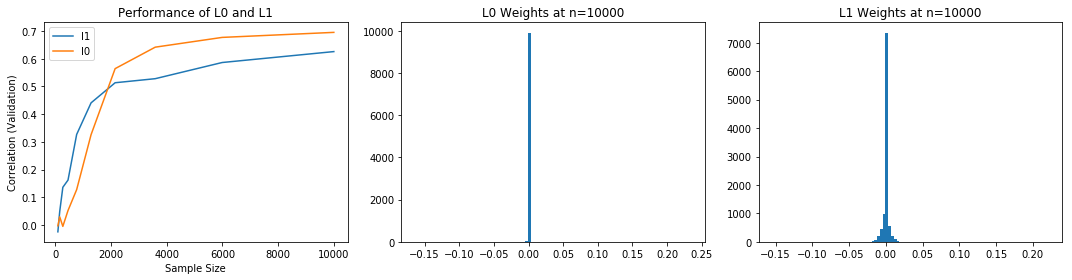

In [207]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4))
for key, item in out.items():
    pred = list()
    for i in item:
        pred.append(i.accu)
    ax[0].plot(sample_limit.astype(int), pred, label=key)
    ax[0].legend()
    ax[0].set_xlabel('Sample Size')
    ax[0].set_ylabel('Correlation (Validation)')
    ax[0].set_title('Performance of L0 and L1')
    
loc = out['l0'][-1].iter_coefs[-1]['linear.loc']
mask = masking(loc)
param = out['l0'][-1].coef['linear.weight'].flatten()

ax[1].hist(param*mask, 100)
ax[1].set_title('L0 Weights at n=10000')
param = out['l1'][-1].coef['linear.weight'].flatten()
ax[2].hist(param, 100)
ax[2].set_title('L1 Weights at n=10000')

fig.tight_layout()
fig.savefig('/home/robert/Documents/projects/ML_genetic_risk/doc/presentation/l0_results/performance.png')

In [134]:
import joypy
loc_iter = list(reversed([k.iter_coefs[-1]['linear.weight'][-1]*masking(k.iter_coefs[-1]['linear.loc']) for k in out['l0']]))
g = list(reversed([str(k) for k in sample_limit]))
l1_param = list(reversed([k.iter_coefs[-1]['linear.weight'][-1] for k in out['l1']]))

In [163]:
loc_iter = list()
l1_param = list()
for i in range(len(out['l0'])):
    weights = out['l0'][i].iter_coefs[-1]['linear.weight'].flatten()
    gates = masking(out['l0'][i].iter_coefs[-1]['linear.loc'].flatten())
    loc_iter.append(weights*gates)
    l1weights = out['l1'][i].iter_coefs[-1]['linear.weight'].flatten()
    l1_param.append(l1weights)

loc_iter = list(reversed(loc_iter))
l1_param = list(reversed(l1_param))

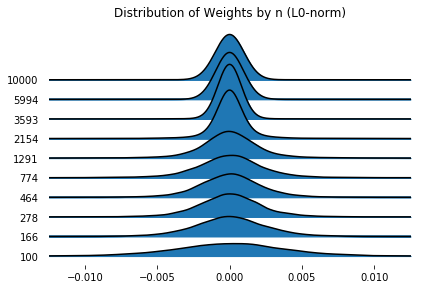

In [214]:
fig, ax = joypy.joyplot(loc_iter, labels=g, x_range=[-0.0125, 0.0125])
ax[-1].set_title('Distribution of Weights by n (L0-norm)')
fig.savefig('/home/robert/Documents/projects/ML_genetic_risk/doc/presentation/l0_results/joyplot_l0.png')

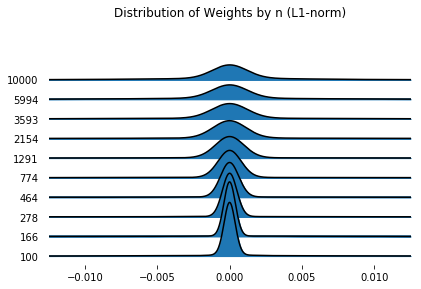

In [215]:
fig, ax = joypy.joyplot(l1_param, labels=g, x_range=[-0.0125, 0.0125])
ax[-1].set_title('Distribution of Weights by n (L1-norm)')
fig.savefig('/home/robert/Documents/projects/ML_genetic_risk/doc/presentation/l0_results/joyplot_l1.png')

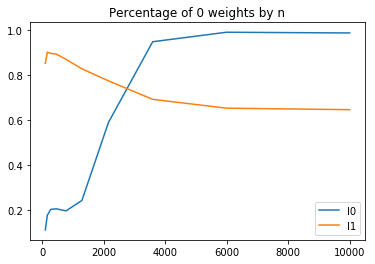

In [210]:
fig, ax = plt.subplots(1,1)
ax.plot([int(k) for k in g], [np.mean(np.round(k, 3)==0) for k in loc_iter], label='l0')
ax.plot([int(k) for k in g], [np.mean(np.round(k, 3)==0) for k in l1_param], label='l1')
ax.set_title('Percentage of 0 weights by n')
ax.legend()
fig.savefig('/home/robert/Documents/projects/ML_genetic_risk/doc/presentation/l0_results/percentage_0_l0l1.png')

In [130]:
bestl0 = out['l0'][-2]
bestl1 = out['l1'][-2]

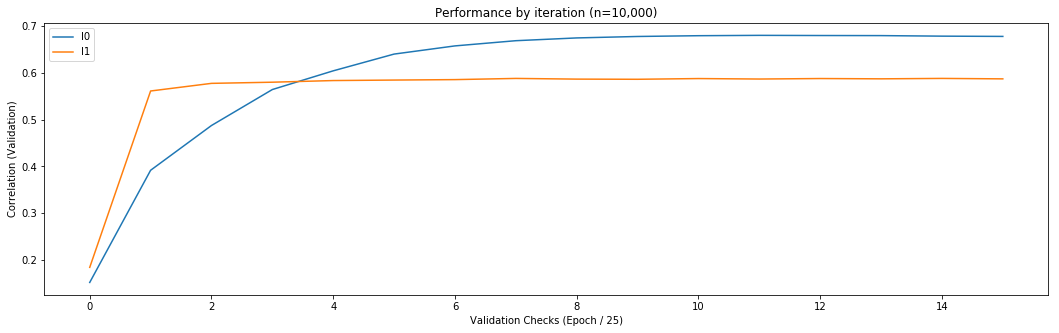

In [230]:
fig, ax = plt.subplots(1,1, figsize=(18, 5))
ax.plot(range(len(bestl0.iter_accu_valid)), bestl0.iter_accu_valid, label='l0')
ax.plot(range(len(bestl1.iter_accu_valid)), bestl1.iter_accu_valid, label='l1')
ax.legend()
ax.set_xlabel('Validation Checks (Epoch / 25)')
ax.set_ylabel('Correlation (Validation)')
ax.set_title('Performance by iteration (n=10,000)')
fig.savefig('/home/robert/Documents/projects/ML_genetic_risk/doc/presentation/l0_results/performance_epochs_l1l0.png')

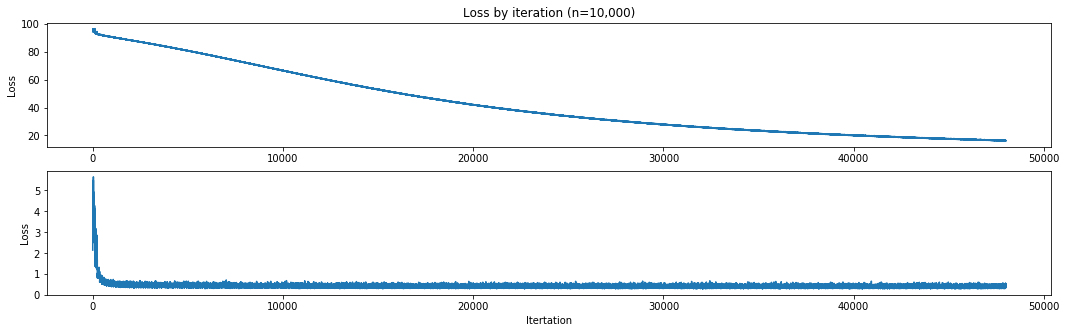

In [229]:
fig, ax = plt.subplots(2,1, figsize=(18, 5))
ax[0].plot(range(len(bestl0.loss)), bestl0.loss)
ax[1].plot(range(len(bestl1.loss)), bestl1.loss)
ax[1].set_xlabel('Itertation')
ax[0].set_ylabel('Loss')
ax[1].set_ylabel('Loss')
ax[0].set_title('Loss by iteration (n=10,000)')
fig.savefig('/home/robert/Documents/projects/ML_genetic_risk/doc/presentation/l0_results/loss_l1l0.png')